In [1]:
import os
import torch
import spacy
import json
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from core.Util import log_matmul, maxmul
from typing import List, Optional
from collections import Counter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

---

## Data Preperation

In [2]:
data_dir = r'data/dataset_ner/'
data_name = 'dev.txt'

In [3]:
with open(os.path.join(data_dir, data_name)) as f:
    lines = f.readlines()

In [4]:
all_sentence = list()
sentence = list()
all_labels = list()
labels = list()
for l in lines:
    try:
        token, _, _, ner_label = l.strip().split()
        sentence.append(token)
        labels.append(ner_label)
    except ValueError:
        all_sentence.append(sentence)
        all_labels.append(labels)
        sentence = list()
        labels = list()

for sentence, labels in zip(all_sentence, all_labels):
    assert len(sentence) == len(labels)

In [5]:
n_label_dict = {}
for labels in all_labels:
    for label in labels:
        if label not in n_label_dict.keys():
            n_label_dict[label] = 1
        else:
            n_label_dict[label] += 1

In [6]:
idx2label = [
    'O',
    'B-ORG',
    'I-ORG',
    'B-LOC',
    'I-LOC',
    'B-PER',
    'I-PER',
    'B-MISC',
    'I-MISC'
]
label2idx = {v: k for k, v in enumerate(idx2label)}

In [8]:
with open(os.path.join('data', 'CoNLL2003-labels.json'), 'w') as f:
    json.dump(idx2label, f)

In [7]:
lb_indices = [[0] + [label2idx[lb] for lb in lbs] for lbs in all_labels]

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,
                 obs: List[List[int]]
                 ):
        """
        A wrapper class to create syntax dataset for syntax expansion training.
        """
        super().__init__()
        self._obs = obs

    @property
    def n_insts(self):
        """ Property for dataset size """
        return len(self._obs)

    def __len__(self):
        return self.n_insts

    def __getitem__(self, idx):
        return self._obs[idx]

def batch_prep(obs_list: List[List[int]]):
    """
    Pad the instance to the max seq length in batch
    """
    seq_lens = [len(obs) for obs in obs_list]
    max_seq_len = np.max(seq_lens)

    obs_batch = np.array([
        inst + [0] * (max_seq_len - len(inst))
        for inst in obs_list
    ])

    obs_batch = torch.tensor(obs_batch, dtype=torch.long)
    seq_lens = torch.tensor(seq_lens, dtype=torch.long)

    return obs_batch, seq_lens

def collate_fn(insts):
    """
    Principle used to construct dataloader

    :param insts: original instances
    :return: padded instances
    """
    batch = batch_prep(insts)
    return batch

---

## Model Construction

In [9]:
def normalize(x, dim=-1):
    result = x - x.min(dim=dim, keepdim=True)[0] + 1e-3
#     result = result / x.max(dim=dim, keepdim=True)[0] * (1-1e-6) + 5e-7
    result = result / result.sum(dim=dim, keepdim=True)
    return result

In [10]:
class Transition(nn.Module):
    """
    Neural Transition Model
    """

    def __init__(self, n_hidden, prior=None):
        super(Transition, self).__init__()
        self.n_hidden = n_hidden  # number of states

        self.trans_prior = prior
        self.unnormalized_tran = None
        self._init_tran()

    def _init_tran(self):
        if self.trans_prior is not None:
            self.unnormalized_tran = nn.Parameter(self.trans_prior)
        else:
            self.unnormalized_tran = nn.Parameter(torch.randn(self.n_hidden, self.n_hidden))
        print("Transition matrix initialized!")

    def forward(self, log_alpha, temperature=1, use_max=False):
        """
        log_alpha : Tensor of shape (batch size, n_hidden_states)

        Multiply previous timestep's alphas by transition matrix (in log domain)
        """
        # Each col needs to add up to 1 (in probability domain)
#         tran = torch.log_softmax(self.unnormalized_tran/temperature, dim=-1)
        tran = torch.log(normalize(self.unnormalized_tran))

        # Matrix multiplication in the log domain
        if use_max:
            out1, out2 = maxmul(log_alpha, tran)
            return out1, out2
        else:
            out = log_matmul(log_alpha, tran)
            return out

In [11]:
class Emission(nn.Module):
    """
    - forward(): computes the log probability of an observation.
    - sample(): given a state, sample an observation for that state.
    """

    def __init__(self, n_hidden, n_obs, prior=None):
        super(Emission, self).__init__()
        self.n_hidden = n_hidden  # number of states
        self.n_obs = n_obs  # number of possible observations

        self.emis_prior = prior
        self.unnormalized_emis = None
        self._init_emis()

    def _init_emis(self):
        if self.emis_prior is not None:
#             self.unnormalized_emis = nn.Parameter(self.emis_prior)
            self.unnormalized_emis = self.emis_prior
        else:
            self.unnormalized_emis = nn.Parameter(torch.randn(self.n_hidden, self.n_obs))
        print("Emission matrix initialized")

    def forward(self, o_t, temperature=1):
        """
        o_t : LongTensor of shape (batch_size)

        Get observation probabilities
        """
        # Each row needs to add up to 1 (in probability domain)
#         emission_matrix = F.log_softmax(self.unnormalized_emis/temperature, dim=-1)
        emission_matrix = torch.log(normalize(self.unnormalized_emis))
        out = emission_matrix[:, o_t].T

        return out

In [12]:
class HMM(nn.Module):
    """
    Neural Hidden Markov Model.
    (For now, discrete obs_set only.)
    - forward(): computes the log probability of an observation sequence.
    - viterbi(): computes the most likely state sequence.
    - sample(): draws a sample from p(obs).
    """

    def __init__(self, args, state_prior=None, trans_prior=None, emis_prior=None):
        super(HMM, self).__init__()

        self.args = args
        self.d_emb = args.d_emb  # embedding dimension
        self.n_obs = args.n_obs  # number of possible obs_set
        self.n_hidden = args.n_hidden  # number of states

        self.transition_model = Transition(self.n_hidden, prior=trans_prior)
        self.emission_model = Emission(self.n_hidden, self.n_obs, prior=emis_prior)

        self.state_prior = state_prior
        self._init_hidden_states()

    def _init_hidden_states(self):
        if self.state_prior is not None:
            self.log_state_priors = torch.log_softmax(state_prior, dim=0)
        else:
            priors = torch.randn(self.n_obs)
            self.log_state_priors = torch.log_softmax(priors, dim=0)
        print("hidden states initialized!")

    def forward(self, obs, lengths):
        """
        obs : IntTensor of shape (batch size, max_length, n_src)
        lengths : IntTensor of shape (batch size)

        Compute log p(obs) for each example in the batch.
        lengths = length of each example
        """
        obs = obs.to(self.args.device)
        lengths = lengths.to(self.args.device)

        s_batch, max_length = obs.size()
        log_alpha = torch.zeros([s_batch, max_length, self.n_hidden], device=self.args.device)

        log_alpha[:, 0, :] = self.emission_model(obs[:, 0]) + self.log_state_priors
        # print(log_alpha[:, 0, :])
        for t in range(1, max_length):
            log_alpha[:, t, :] = self.emission_model(obs[:, t]) + self.transition_model(
                log_alpha=log_alpha[:, t-1, :], use_max=False
            )
            # print(log_alpha[:, t, :])

        log_sums = log_alpha.logsumexp(dim=2)

        # Select the sum for the final timestep (each obs has different length).
        log_probs = torch.gather(log_sums, 1, lengths.view(-1, 1) - 1)
        return log_probs

    def viterbi(self, obs, lengths):
        """
        obs : IntTensor of shape (batch size, max_len, n_src)
        lengths : IntTensor of shape (batch size)

        Find argmax_z log p(z|obs) for each (obs) in the batch.
        """
        obs = obs.to(self.args.device)
        lengths = lengths.to(self.args.device)

        s_batch, max_len = obs.size()
        log_delta = torch.zeros([s_batch, max_len, self.n_hidden], device=self.args.device)
        psi = torch.zeros([s_batch, max_len, self.n_hidden], dtype=torch.long, device=self.args.device)

        log_delta[:, 0, :] = self.emission_model(obs[:, 0]) + self.log_state_priors
        for t in range(1, max_len):
            max_val, argmax_val = self.transition_model(
                log_alpha=log_delta[:, t - 1, :], use_max=True
            )
            log_delta[:, t, :] = self.emission_model(obs[:, t]) + max_val
            psi[:, t, :] = argmax_val

        # Get the probability of the best data_path
        log_max = log_delta.max(dim=2)[0]
        best_path_scores = torch.gather(log_max, 1, lengths.view(-1, 1) - 1)

        # This next part is a bit tricky to parallelize across the batch,
        # so we will do it separately for each example.
        z_star = []
        for i in range(0, s_batch):
            z_star_i = [log_delta[i, lengths[i] - 1, :].max(dim=0)[1].item()]
            for t in range(lengths[i] - 1, 0, -1):
                z_t = psi[i, t, z_star_i[0]].item()
                z_star_i.insert(0, z_t)

            z_star.append(z_star_i)

        return z_star, best_path_scores


---

# Training

In [13]:
from argparse import Namespace
args = Namespace(
    batch_size=128,
    d_emb=768,
    device=torch.device('cpu'),
    dropout=0.1,
    epoch=50,
    lr=0.001,
    model_dir='.',
    n_hidden=len(idx2label),
    n_obs=len(idx2label),
    num_workers=0,
    pin_memory=False,
    random_seed=42,
    test_size=0.1
)

In [14]:
data_set = Dataset(obs=lb_indices)

data_loader = torch.utils.data.DataLoader(
    dataset=data_set,
    num_workers=0,
    batch_size=args.batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    pin_memory=False,
    drop_last=False
)

In [15]:
emis_prior = torch.eye(args.n_hidden)
# emis_prior = None
state_prior = torch.zeros(args.n_hidden, device=args.device)+ 1e-2
state_prior[0] += 1 - state_prior.sum()

tr_matrix = np.zeros([len(label2idx), len(label2idx)])
for lb_index in lb_indices:
    for l0, l1 in zip(lb_index[:-1], lb_index[1:]):
        tr_matrix[l0, l1] += 1
tr_matrix = tr_matrix / tr_matrix.sum(axis=1).reshape(len(label2idx), 1)
tr_matrix = torch.tensor(tr_matrix)
tr_matrix = None

model = HMM(args=args, state_prior=state_prior, trans_prior=tr_matrix, emis_prior=emis_prior)

Transition matrix initialized!
Emission matrix initialized
hidden states initialized!


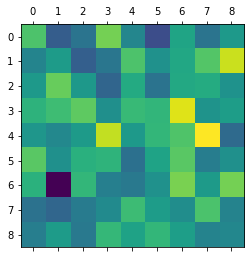

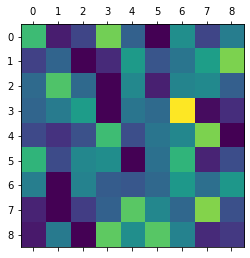

In [16]:
# plt.matshow(torch.softmax(model.transition_model.unnormalized_tran, dim=-1).detach().numpy())
plt.matshow(model.transition_model.unnormalized_tran.detach().numpy())
plt.show()
plt.matshow(normalize(model.transition_model.unnormalized_tran.detach()).numpy())
plt.show()

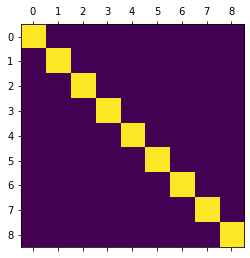

In [17]:
# plt.matshow(torch.softmax(model.emission_model.unnormalized_emis, dim=-1).detach().numpy())
plt.matshow(normalize(model.emission_model.unnormalized_emis.detach()).numpy())

In [18]:
class Trainer:
    def __init__(self, model, args):
        self.model = model
        self.args = args

        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=args.lr,
            weight_decay=1e-5
        )

    def train(self, data_loader):

        train_loss = 0
        num_samples = 0

        self.model.train()

        for batch in tqdm(data_loader):
            obs_batch, seq_lens = batch
            batch_size = len(obs_batch)
            num_samples += batch_size
            # log_probs = self.model(embs=emb_batch, obs=obs_batch, lengths=seq_lens)
            log_probs = self.model(obs=obs_batch, lengths=seq_lens)
            loss = -log_probs.mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.cpu().data.numpy().item() * batch_size
        train_loss /= num_samples

        print(train_loss)

        return train_loss
    
    def test(self, data_loader, idx2label):

        self.model.eval()

        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                obs_batch, seq_lens = batch
                # label_indices, confs = self.model.viterbi(emb_batch, obs_batch, seq_lens)
                label_indices, confs = self.model.viterbi(obs_batch, seq_lens)
                labels = [[idx2label[li] for li in lbs] for lbs in label_indices]
                true_obs = [[idx2label[li.item()] for li in lbs] for lbs in obs_batch]
                for n in range(len(obs_batch)):
                    print(labels[n])
                    print(true_obs[n])
                    print()
                if i > 0:
                    break
        return confs

trainer = Trainer(model, args)

========= Epoch 1 of 50 =========



31.996022151066708


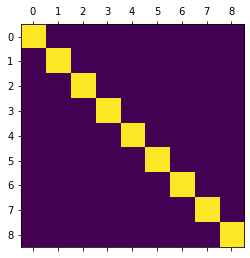

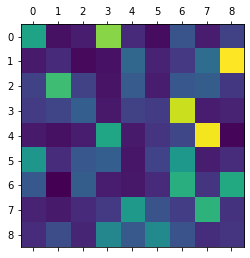

========= Results: epoch 1 of 50 =========
train loss: 32.00

========= Epoch 2 of 50 =========



31.5884444134052


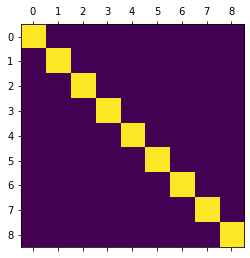

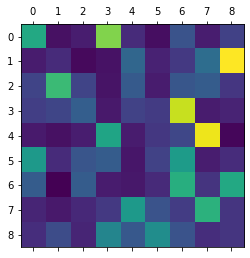

========= Results: epoch 2 of 50 =========
train loss: 31.59

========= Epoch 3 of 50 =========



31.184944623506986


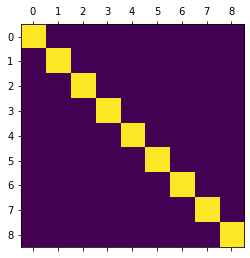

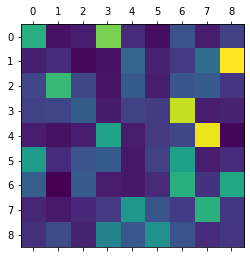

========= Results: epoch 3 of 50 =========
train loss: 31.18

========= Epoch 4 of 50 =========



30.779834614680365


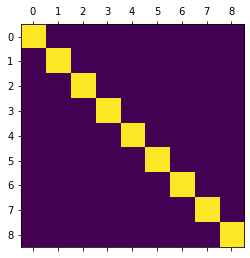

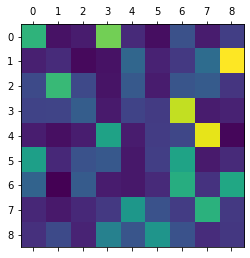

========= Results: epoch 4 of 50 =========
train loss: 30.78

========= Epoch 5 of 50 =========



30.3688277153602


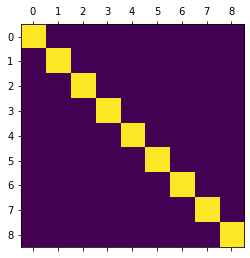

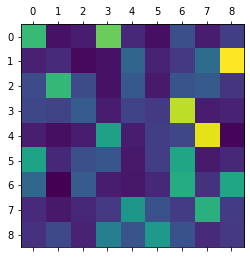

========= Results: epoch 5 of 50 =========
train loss: 30.37

========= Epoch 6 of 50 =========



29.94610109769381


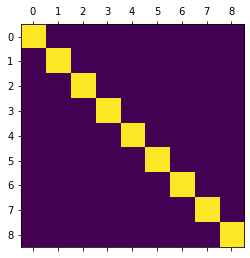

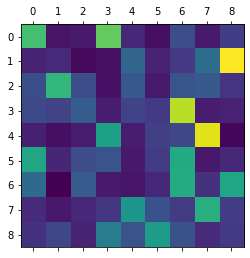

========= Results: epoch 6 of 50 =========
train loss: 29.95

========= Epoch 7 of 50 =========



29.514548713097206


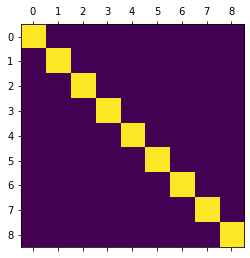

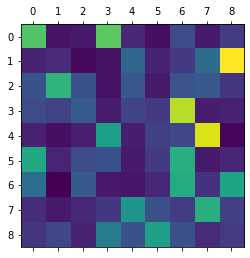

========= Results: epoch 7 of 50 =========
train loss: 29.51

========= Epoch 8 of 50 =========



29.071182621882514


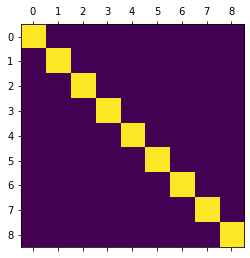

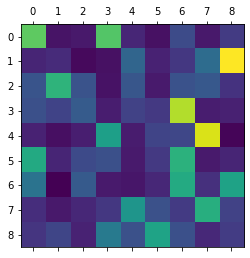

========= Results: epoch 8 of 50 =========
train loss: 29.07

========= Epoch 9 of 50 =========



28.608519008929914


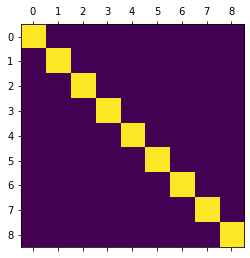

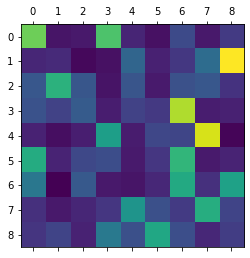

========= Results: epoch 9 of 50 =========
train loss: 28.61

========= Epoch 10 of 50 =========



28.133574923001802


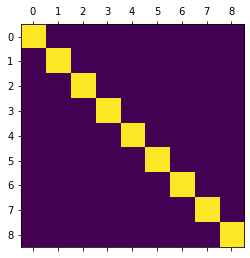

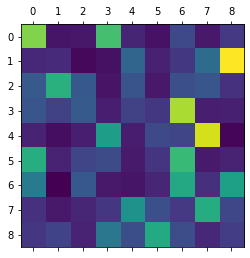

========= Results: epoch 10 of 50 =========
train loss: 28.13

========= Epoch 11 of 50 =========



27.638767326941856


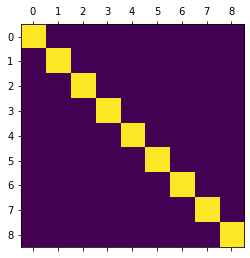

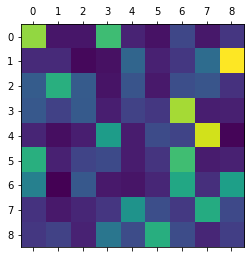

========= Results: epoch 11 of 50 =========
train loss: 27.64

========= Epoch 12 of 50 =========



27.127074377206657


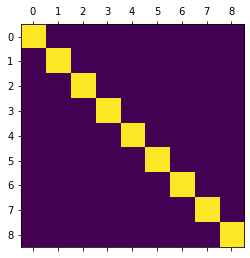

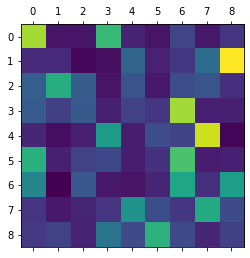

========= Results: epoch 12 of 50 =========
train loss: 27.13

========= Epoch 13 of 50 =========



26.604199721116284


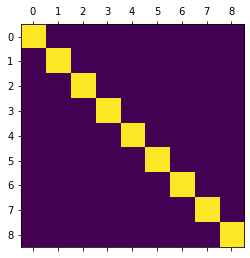

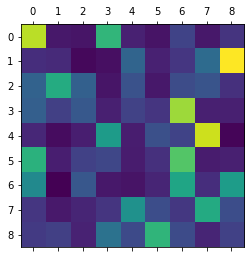

========= Results: epoch 13 of 50 =========
train loss: 26.60

========= Epoch 14 of 50 =========



25.932161423903246


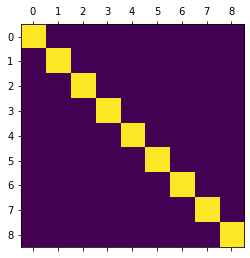

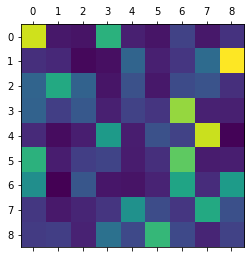

========= Results: epoch 14 of 50 =========
train loss: 25.93

========= Epoch 15 of 50 =========



24.623941606961765


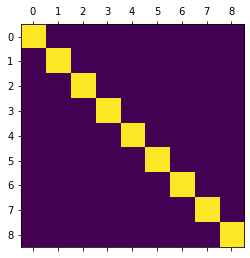

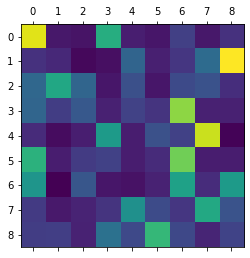

========= Results: epoch 15 of 50 =========
train loss: 24.62

========= Epoch 16 of 50 =========



24.166728358342098


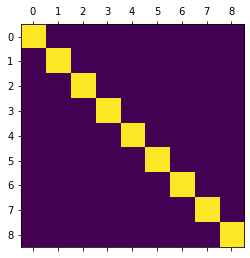

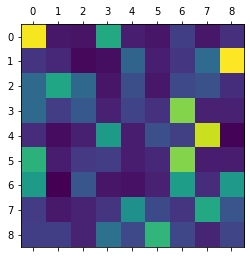

========= Results: epoch 16 of 50 =========
train loss: 24.17

========= Epoch 17 of 50 =========



23.768822158813478


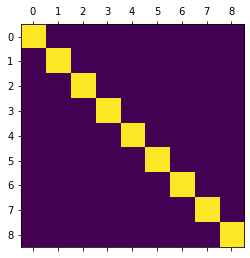

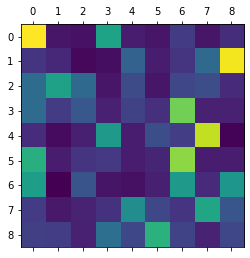

========= Results: epoch 17 of 50 =========
train loss: 23.77

========= Epoch 18 of 50 =========



23.372802274263822


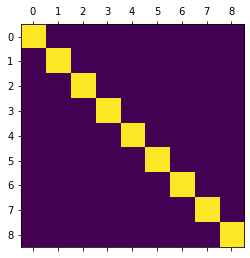

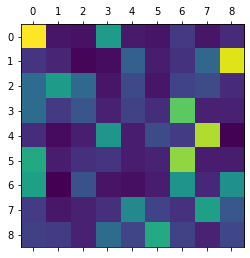

========= Results: epoch 18 of 50 =========
train loss: 23.37

========= Epoch 19 of 50 =========



22.966042131864107


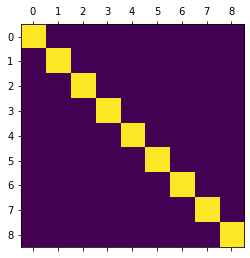

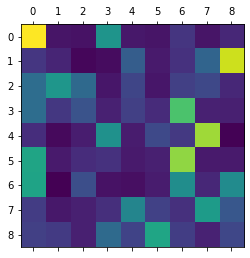

========= Results: epoch 19 of 50 =========
train loss: 22.97

========= Epoch 20 of 50 =========



22.552025171133188


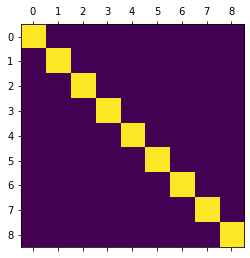

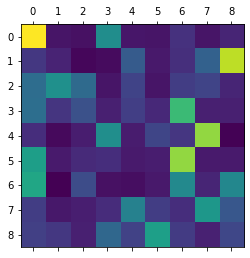

========= Results: epoch 20 of 50 =========
train loss: 22.55

========= Epoch 21 of 50 =========



22.12056755887545


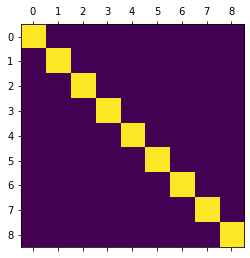

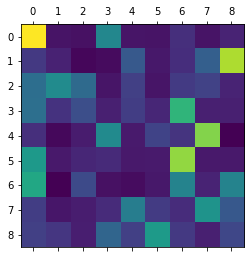

========= Results: epoch 21 of 50 =========
train loss: 22.12

========= Epoch 22 of 50 =========



21.677611857487605


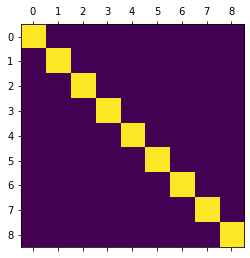

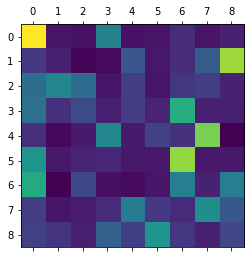

========= Results: epoch 22 of 50 =========
train loss: 21.68

========= Epoch 23 of 50 =========



21.21307906282865


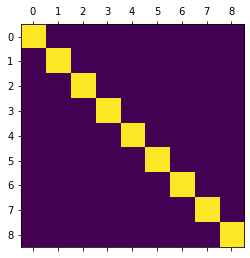

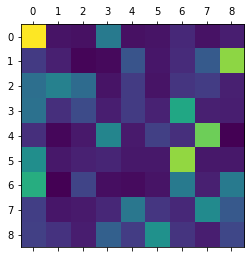

========= Results: epoch 23 of 50 =========
train loss: 21.21

========= Epoch 24 of 50 =========



20.735158349844127


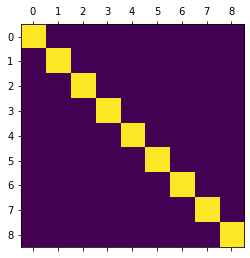

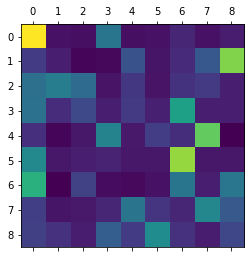

========= Results: epoch 24 of 50 =========
train loss: 20.74

========= Epoch 25 of 50 =========



20.327540184607873


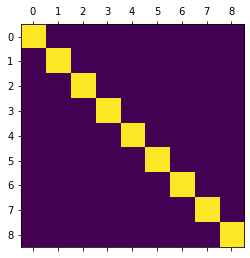

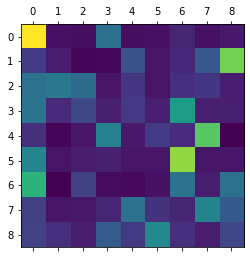

========= Results: epoch 25 of 50 =========
train loss: 20.33

========= Epoch 26 of 50 =========



19.958328856248123


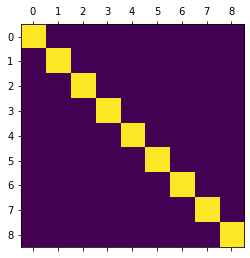

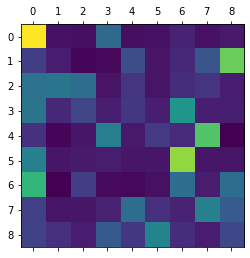

========= Results: epoch 26 of 50 =========
train loss: 19.96

========= Epoch 27 of 50 =========



19.586130857027495


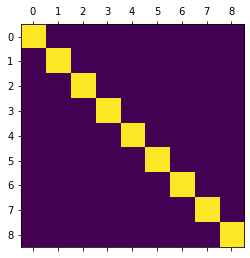

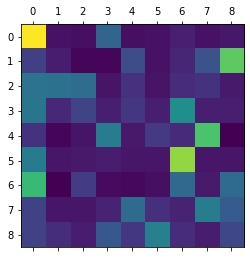

========= Results: epoch 27 of 50 =========
train loss: 19.59

========= Epoch 28 of 50 =========



19.207213341346154


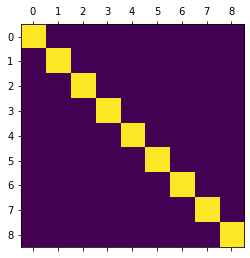

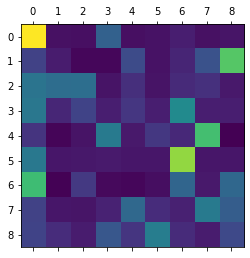

========= Results: epoch 28 of 50 =========
train loss: 19.21

========= Epoch 29 of 50 =========



18.816844849806564


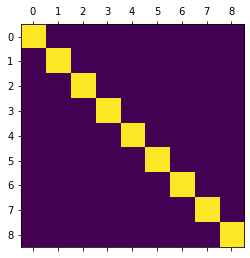

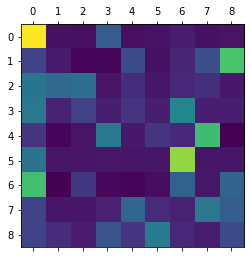

========= Results: epoch 29 of 50 =========
train loss: 18.82

========= Epoch 30 of 50 =========



18.272461910541242


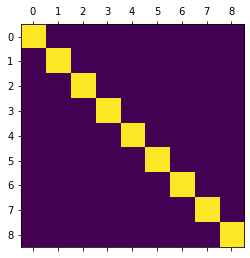

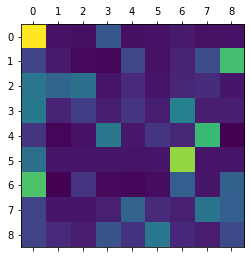

========= Results: epoch 30 of 50 =========
train loss: 18.27

========= Epoch 31 of 50 =========



17.74536241502028


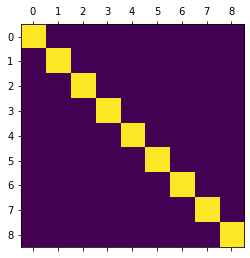

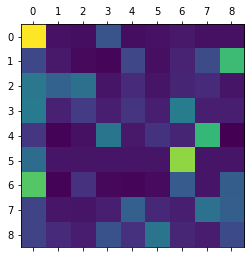

========= Results: epoch 31 of 50 =========
train loss: 17.75

========= Epoch 32 of 50 =========



17.281492591271032


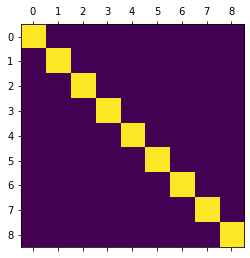

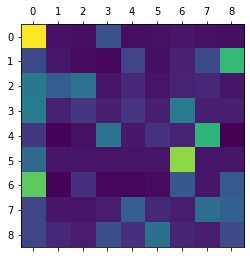

========= Results: epoch 32 of 50 =========
train loss: 17.28

========= Epoch 33 of 50 =========



16.815585473867564


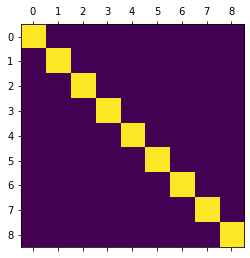

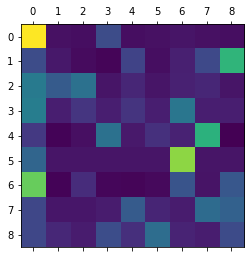

========= Results: epoch 33 of 50 =========
train loss: 16.82

========= Epoch 34 of 50 =========



16.41422624323918


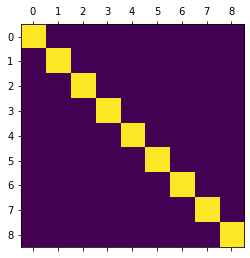

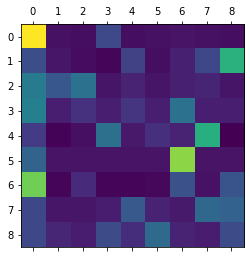

========= Results: epoch 34 of 50 =========
train loss: 16.41

========= Epoch 35 of 50 =========



16.09747448378343


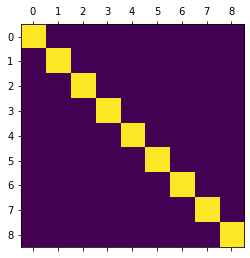

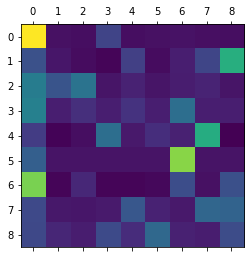

========= Results: epoch 35 of 50 =========
train loss: 16.10

========= Epoch 36 of 50 =========



15.789676990215595


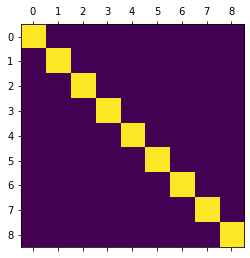

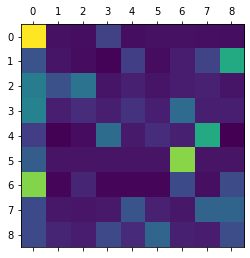

========= Results: epoch 36 of 50 =========
train loss: 15.79

========= Epoch 37 of 50 =========



15.48767777310885


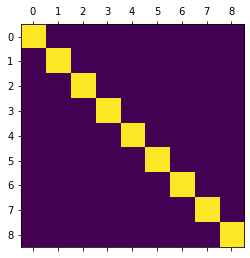

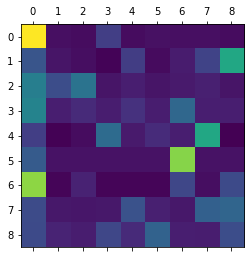

========= Results: epoch 37 of 50 =========
train loss: 15.49

========= Epoch 38 of 50 =========



15.180872733482948


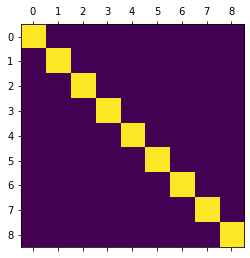

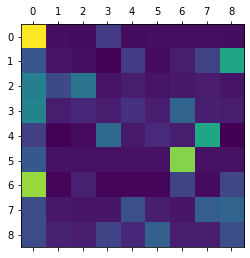

========= Results: epoch 38 of 50 =========
train loss: 15.18

========= Epoch 39 of 50 =========



14.873245006854718


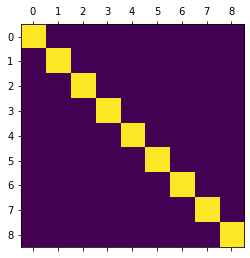

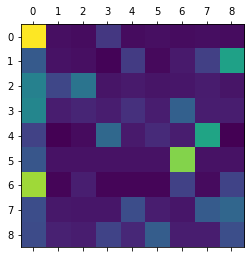

========= Results: epoch 39 of 50 =========
train loss: 14.87

========= Epoch 40 of 50 =========



14.612534534160908


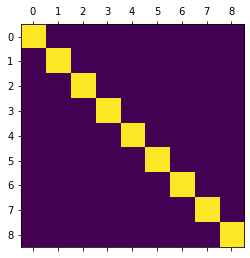

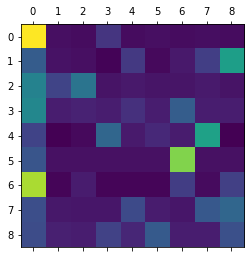

========= Results: epoch 40 of 50 =========
train loss: 14.61

========= Epoch 41 of 50 =========



14.427783385056715


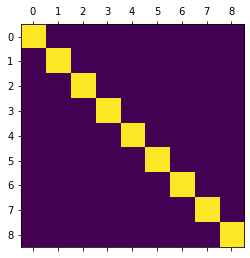

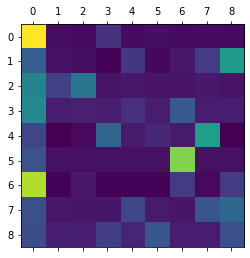

========= Results: epoch 41 of 50 =========
train loss: 14.43

========= Epoch 42 of 50 =========



14.265378379821778


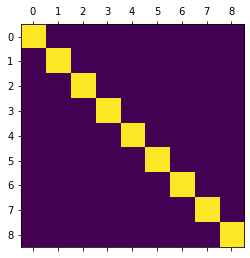

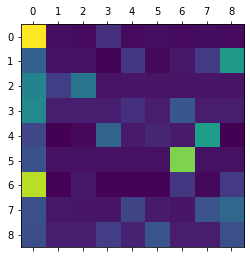

========= Results: epoch 42 of 50 =========
train loss: 14.27

========= Epoch 43 of 50 =========



14.104748144883375


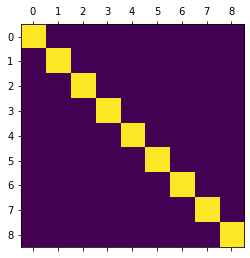

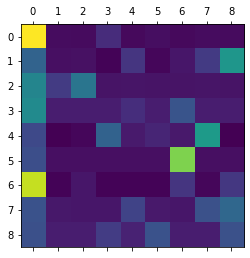

========= Results: epoch 43 of 50 =========
train loss: 14.10

========= Epoch 44 of 50 =========



13.950042501009428


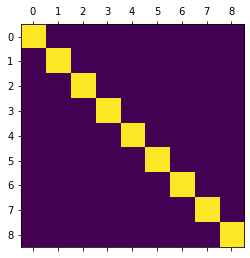

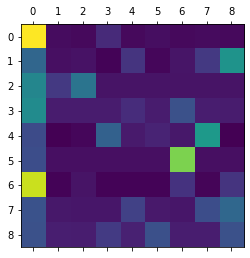

========= Results: epoch 44 of 50 =========
train loss: 13.95

========= Epoch 45 of 50 =========



13.8049420805711


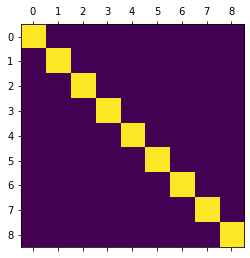

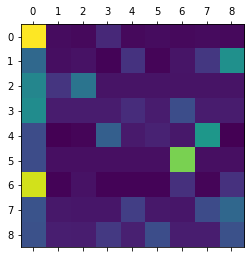

========= Results: epoch 45 of 50 =========
train loss: 13.80

========= Epoch 46 of 50 =========



13.665603534405047


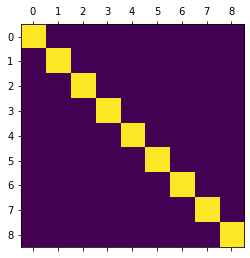

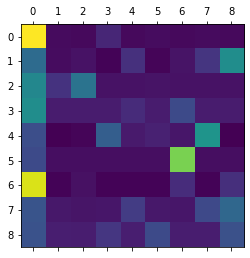

========= Results: epoch 46 of 50 =========
train loss: 13.67

========= Epoch 47 of 50 =========



13.527430401728703


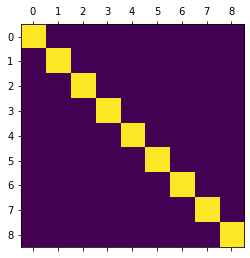

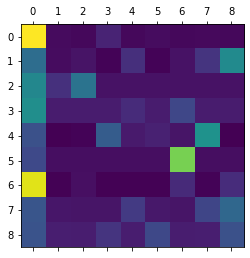

========= Results: epoch 47 of 50 =========
train loss: 13.53

========= Epoch 48 of 50 =========



13.391847650381235


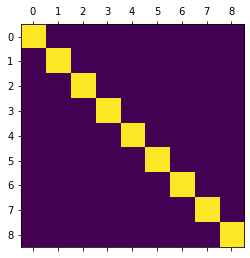

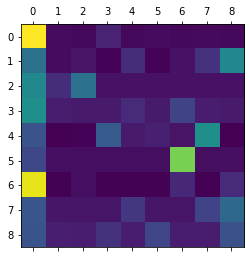

========= Results: epoch 48 of 50 =========
train loss: 13.39

========= Epoch 49 of 50 =========



13.262496897770808


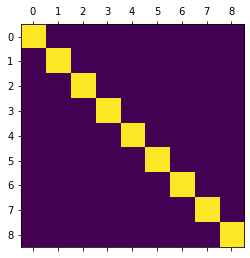

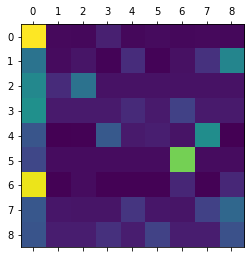

========= Results: epoch 49 of 50 =========
train loss: 13.26

========= Epoch 50 of 50 =========



13.129149026724008


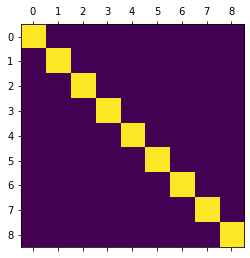

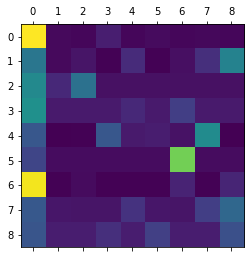

========= Results: epoch 50 of 50 =========
train loss: 13.13



In [19]:
for epoch in range(args.epoch):
    print("========= Epoch %d of %d =========" % (epoch + 1, args.epoch))
    train_loss = trainer.train(data_loader)
    # valid_loss = trainer.test(valid_dataset)
#     trainer.save_checkpoint()
    plt.matshow(normalize(model.emission_model.unnormalized_emis, dim=-1).detach().numpy())
    plt.show()
    plt.matshow(normalize(model.transition_model.unnormalized_tran, dim=-1).detach().numpy())
    plt.show()

    print("========= Results: epoch %d of %d =========" % (epoch + 1, args.epoch))
    print("train loss: %.2f\n" % train_loss)

In [20]:
test_set = Dataset(obs=lb_indices)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    num_workers=0,
    batch_size=5,
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
    drop_last=False
)

trainer.test(test_loader, idx2label)

['O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

['O', 'B-LOC', 'O']
['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

['O', 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O'

tensor([[-17.3419],
        [-28.0877],
        [-22.1890],
        [-22.2983],
        [-29.9461]])

In [21]:
torch.softmax(model.transition_model.unnormalized_tran, dim=-1).detach().numpy()

array([[0.65836394, 0.04037013, 0.03601024, 0.07635742, 0.03599975,
        0.04207487, 0.03602672, 0.03879702, 0.03599989],
       [0.27205515, 0.04038173, 0.06022592, 0.02908197, 0.10184719,
        0.02909644, 0.05092265, 0.11088222, 0.30550668],
       [0.3219488 , 0.09755497, 0.26097098, 0.05326961, 0.05310426,
        0.05330766, 0.05330361, 0.05326979, 0.05327036],
       [0.34347767, 0.06942362, 0.06946537, 0.06939447, 0.09818671,
        0.06957194, 0.14124712, 0.06973505, 0.06949803],
       [0.19668356, 0.02422754, 0.0277979 , 0.19760507, 0.06993217,
        0.07519352, 0.05530291, 0.32904845, 0.0242089 ],
       [0.15666728, 0.04553036, 0.04552503, 0.04552421, 0.04556599,
        0.04550533, 0.524535  , 0.0455265 , 0.04562029],
       [0.64680207, 0.02719102, 0.0416164 , 0.02710887, 0.02712038,
        0.02716027, 0.08697483, 0.02709829, 0.0889279 ],
       [0.19880012, 0.06271493, 0.06039605, 0.06025704, 0.11804251,
        0.0628891 , 0.06022184, 0.14136745, 0.23531105],


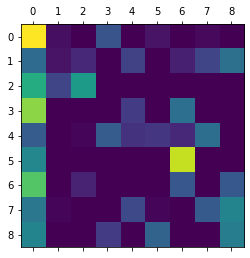

In [24]:
plt.matshow(normalize(model.transition_model.unnormalized_tran, dim=-1).detach().numpy())

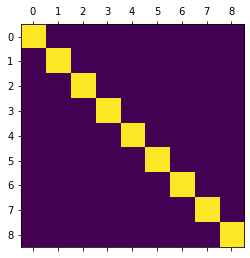

In [23]:
plt.matshow(torch.softmax(model.emission_model.unnormalized_emis, dim=-1).detach().numpy())